# Linear LLM-innovator evolution chain

This notebook showcases a simple example run of linear evolution with a LLM-innovator on the kernel density estimation (KDE) challenge problem. 


### Table of contents
1. [Run LLM-innovation loop](#loop)
2. [Visualise KDE instances](#visualise)

In [1]:
import os
import traceback
import time

import numpy as np

import matplotlib.pyplot as plt


# challenge
import src
import run_challenge_instance


# local env
from dotenv import load_dotenv, find_dotenv

env_name = '.env'
load_dotenv(find_dotenv(env_name))

NANOGPT_APIKEY = os.getenv("NANOGPT_APIKEY")


# past nanoGPT API call data
import json

with open('nanoGPT_models.json', 'r') as f:
    a = json.load(f)
    
model_names = [aa['id'] for aa in a['data']]

In [3]:
a = {'a': 1, 2: 'nnd'}

f"{a} a"

"{'a': 1, 2: 'nnd'} a"

<a id="loop"></a>
## 1. Run LLM-innovation loop

In [2]:
run_seed = 1
LLM_temperature = 1.0
LLM_name = "chatgpt-4o-latest"#"auto-model-basic"#"deepseek-r1-nano"#
max_prompt_iters = 64
LLM_prompt_time_ms = int(time.time() * 1000)  # ms, include as we don't have seed control of LLM API

challenge_params = {
    'dims': 2, 
    'num_train_pts': 2 ** 9, 
    'num_test_pts': 2 ** 7, 
}


# experiment name
exp_name = 'KDE'
folder_name = f'seed{run_seed}iters{max_prompt_iters}time{LLM_prompt_time_ms}'

# local package
import sys
sys.path.append(f'{exp_name}/')
import template


dir_path = f'{exp_name}/{folder_name}/'
os.makedirs(dir_path, exist_ok=True)

logger = src.logger.setup_logger(logger_name='linear_evolution', logger_filename=None)

In [3]:
system_prompt = run_challenge_instance.build_system_prompt(
    template.algorithm_prompt, template.feedback_prompt, template.first_algorithm)
print(system_prompt)

EvaluateAlgorithm, ConstructFeedback = src.utils.import_model_specific_symbols(
    exp_name + '/template.py', ['EvaluateAlgorithm', 'ConstructFeedback'])


Code up an algorithm in Python 3 with the following goals and specifications: 
Write a function that takes in training data points of shape (num_pts, D) and spits out a D-dimensional Gaussian mixture model through parameters: component weight logits of shape (num_comps,), component means (num_comps, D) and component covariances (num_comps, D, D). 
You are implementing kernel density estimation using some form of bandwidth selection heuristic for your base kernel of choice.
Use only NumPy and implement the rest from scratch.

I will run your algorithm on a set of problem instances and report back to you: 
Target score to maximize is your test likelihoods on a fixed set of problem instances (different datasets, here we test on 64 instances), we provide both per instance likelihoods and a single average over instances. In addition, you will get:
- Train data likelihoods (per instance and averaged)
- Time to run evaluation for all instances (we want this to be as low as possible, but prio

In [4]:
api = src.llm.OpenAIAPI(provider="nanogpt")
api.set_api_key(NANOGPT_APIKEY)

model = src.llm.BaseLLM(LLM_name, LLM_temperature)
model.set_api(api)
model.set_system_prompt(system_prompt)

In [5]:
logger.info("Generating initial seed algorithm...")

dir_path = f'{exp_name}/{folder_name}/'
os.makedirs(dir_path, exist_ok=True)


algo_id = 1
with open(dir_path + f'algo{algo_id}.py', 'w') as f:
    f.write(template.first_algorithm)

try:
    eval_results = EvaluateAlgorithm(run_seed, challenge_params, dir_path + f'algo{algo_id}.py')
    try:
        feedback_prompt = ConstructFeedback(eval_results)
    except Exception as err:
        error_str = traceback.format_exc()
        feedback_prompt = 'ConstructFeedback error: ' + str(err) + "\nTraceback: " + error_str

except Exception as err:
    error_str = traceback.format_exc()
    feedback_prompt = 'EvaluateAlgorithms error: ' + str(err) + "\nTraceback: " + error_str

feedback_prompt_list = [feedback_prompt]

logger.info(f"Sending algorithm {algo_id} prompt...")
receive_status, receive_message = model.send_prompt(feedback_prompt)
if receive_status:
    pycode = receive_message.split('<python>')[1].split('</python>')[0]
    reasontext = receive_message.split('<reasoning>')[1].split('</reasoning>')[0]

    pycode_list = [pycode]
    reasontext_list = [reasontext]
    
else:
    logger.error(receive_status)
    raise ValueError(receive_status)




logger.info("Starting LLM-innovation evolution loop...")
start_time = time.time()


invalid_response_retry = False
algo_id = 2
while algo_id < max_prompt_iters + 1:

    if invalid_response_retry is False:
        with open(dir_path + f'algo{algo_id}.py', 'w') as f:
            f.write(pycode)
        
        try:
            eval_results = EvaluateAlgorithm(run_seed, challenge_params, dir_path + f'algo{algo_id}.py')
            try:
                feedback_prompt = ConstructFeedback(eval_results)
            except Exception as err:
                error_str = traceback.format_exc()
                feedback_prompt = 'ConstructFeedback error: ' + str(err) + "\nTraceback: " + error_str

        except Exception as err:
            error_str = traceback.format_exc()
            feedback_prompt = 'EvaluateAlgorithms error: ' + str(err) + "\nTraceback: " + error_str

    feedback_prompt_list.append(feedback_prompt)
    
    if algo_id == max_prompt_iters:
        break  # finish with final feedback
    
    logger.info(f"Sending algorithm {algo_id} prompt...")
    receive_status, receive_message = model.send_prompt(feedback_prompt)
    if receive_status:
        try:
            pycode = receive_message.split('<python>')[1].split('</python>')[0]
            reasontext = receive_message.split('<reasoning>')[1].split('</reasoning>')[0]

            pycode_list.append(pycode)
            reasontext_list.append(reasontext)
            invalid_response_retry = False
            algo_id += 1

        except Exception as err:
            feedback_prompt = 'Response formatting error: ' + str(err)

            # insert an empty entry in the evolution trajectory
            pycode_list.append(None)
            reasontext_list.append(None)

            invalid_response_retry = True  # retry at same algorithm index
        
    else:
        logger.error(receive_status)
        raise ValueError(receive_status)


loop_elapsed_time = time.time() - start_time
logger.info(f"Completed loop in {loop_elapsed_time:.2f} seconds...")

# export
logger.info(f"Saving evolution trajectory...")


with open(dir_path + "reasoning.json", "w") as f:
    json.dump({i: prompt for i, prompt in enumerate(reasontext_list)}, f)

with open(dir_path + "feedback.json", "w") as f:
    json.dump({i: prompt for i, prompt in enumerate(feedback_prompt_list)}, f)

2025-05-28 11:07:43 - linear_evolution - INFO - Generating initial seed algorithm...
2025-05-28 11:07:47 - linear_evolution - INFO - Sending algorithm 1 prompt...
2025-05-28 11:07:55 - linear_evolution - INFO - Starting LLM-innovation evolution loop...
2025-05-28 11:07:56 - linear_evolution - INFO - Sending algorithm 2 prompt...
2025-05-28 11:08:08 - linear_evolution - INFO - Sending algorithm 3 prompt...
2025-05-28 11:08:18 - linear_evolution - INFO - Sending algorithm 4 prompt...
2025-05-28 11:08:27 - linear_evolution - INFO - Sending algorithm 5 prompt...
2025-05-28 11:08:39 - linear_evolution - INFO - Sending algorithm 6 prompt...
2025-05-28 11:08:51 - linear_evolution - INFO - Sending algorithm 7 prompt...
2025-05-28 11:09:01 - linear_evolution - INFO - Sending algorithm 8 prompt...
2025-05-28 11:09:12 - linear_evolution - INFO - Sending algorithm 9 prompt...
2025-05-28 11:09:22 - linear_evolution - INFO - Sending algorithm 10 prompt...
2025-05-28 11:09:32 - linear_evolution - INF

In [134]:
# load
run_seed = 1
LLM_temperature = 1.0
LLM_name = "chatgpt-4o-latest"#"auto-model-basic"#"deepseek-r1-nano"#
max_prompt_iters = 256#64
LLM_prompt_time_ms = 1748421522466#1748426861348seed123iters64time
challenge_params = {
    'dims': 2, 
    # 'num_train_pts': 2 ** 8, 
    # 'num_test_pts': 2 ** 5, 
    'num_train_pts': 2 ** 9, 
    'num_test_pts': 2 ** 7, 
}


# experiment name
exp_name = 'KDE'
folder_name = f'seed{run_seed}iters{max_prompt_iters}time{LLM_prompt_time_ms}'
dir_path = f'{exp_name}/{folder_name}/'

In [135]:
with open(dir_path + "reasoning.json", "r") as f:
   reasontext_dict = json.load(f)

with open(dir_path + "feedback.json", "r") as f:
   feedback_prompt_dict = json.load(f)

In [219]:
reasontext_dict['143']

"\nThe target test likelihoods are low for the chosen approach using Silverman's rule. To improve, I switched to Scott's rule for bandwidth selection, which is generally suitable for multi-dimensional datasets (Dims > 1). Scott’s rule considers the dimensionality of data and may better handle multi-dimensional settings, possibly improving overall performance. \n\nScott’s rule adjusts the bandwidth computation to balance between bias and variance for higher-dimensional data, with the hope that this produces better-suited Gaussian kernels and improves test log-likelihoods. Beyond this change, the rest of the code structure is left untouched to minimize unnecessary complexity and ensure clarity.\n\nThis adjustment doesn't increase code length or computational overhead significantly but is expected to provide better results. I chose to focus on maintaining low code complexity, efficient evaluation, and slight improvement in model fit.\n"

In [137]:
import ast

test_log_likelihood_averages, elapsed_time_seconds = [], []
for i in range(max_prompt_iters):
    if feedback_prompt_dict[str(i)][0] != '{':  # error
        test_log_likelihood_averages.append(np.nan)
        elapsed_time_seconds.append(np.nan)
        continue

    safe_dict = ast.literal_eval(feedback_prompt_dict[str(i)])

    test_log_likelihood_averages.append(safe_dict['test_log_likelihood_average'])
    elapsed_time_seconds.append(safe_dict['elapsed_time_seconds'])

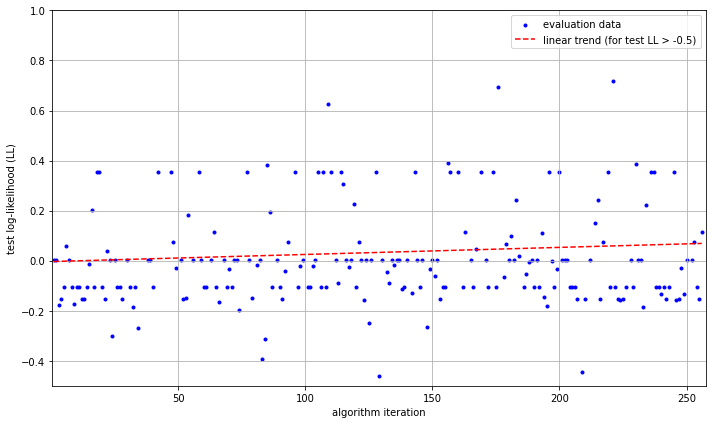

In [140]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
import pandas as pd

# Your data
y = np.array(test_log_likelihood_averages)
x = np.arange(len(y))

sel_inds = np.where(y > -0.5)[0]
y_ = y[sel_inds]
x_ = x[sel_inds]

# Linear regression
slope, intercept, r_value, p_value, std_err = linregress(x_, y_)
y_pred = slope * x + intercept


# Plot everything
plt.figure(figsize=(10, 6))
plt.scatter(1 + x, y, label="evaluation data", color='blue', marker='.')
plt.plot(1 + x, y_pred, label="linear trend (for test LL > -0.5)", linestyle='--', color='red')
plt.ylim(-0.5, 1)
plt.xlim(0.5, len(x) + 1.5)
plt.xlabel("algorithm iteration")
plt.ylabel("test log-likelihood (LL)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

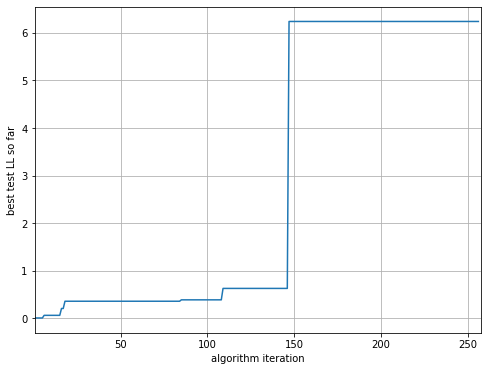

In [152]:
rolling_max = [np.nan_to_num(test_log_likelihood_averages, nan=-np.inf)[:i + 1].max() for i in range(max_prompt_iters)]

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, max_prompt_iters + 1), rolling_max)
plt.grid('on')
plt.xlabel("algorithm iteration")
plt.ylabel('best test LL so far')
plt.xlim(0.5, max_prompt_iters + 1.5)
plt.show()

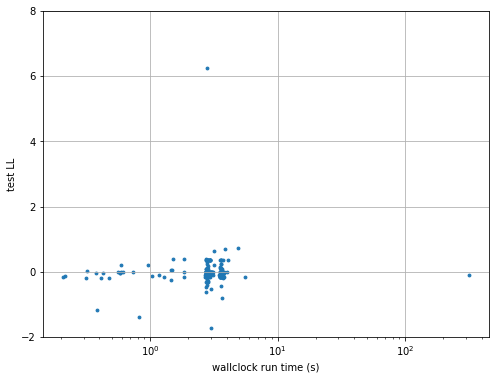

In [143]:
plt.figure(figsize=(8, 6))
plt.scatter(elapsed_time_seconds, test_log_likelihood_averages, s=8)
plt.xscale('log')
plt.xlabel('wallclock run time (s)')
plt.ylabel('test LL')
plt.ylim(-2, 8)
plt.grid('on')

In [169]:
scores_corrected = np.nan_to_num(test_log_likelihood_averages, nan=-np.inf)

print(np.argmax(scores_corrected) + 1)

147


In [204]:
np.array(test_log_likelihood_averages)[242]

-0.10655233242274278

<a id="visualise"></a>
## 2. Visualise KDE instances

In [209]:
dims = challenge_params['dims']
instances_seed = run_seed
algo_id = 243
algo_script_file = dir_path + f'algo{algo_id}.py'



# generate instance
algorithm_func, = src.utils.import_model_specific_symbols(algo_script_file, ['algorithm_func'])

# evaluation
num_instances = 64
start_time = time.time()

grid_pts = 128


plot_data = []
for i in range(8):
    print(f'{i + 1} / {num_instances}')

    seed = instances_seed + i

    rng_samps = np.random.default_rng(seed + 1)

    num_samples = challenge_params['num_train_pts']
    z = rng_samps.normal(size=(num_samples, dims))
    rng_params = np.random.default_rng(seed)
    train_xs = template.generate_samples(rng_params, z)

    num_samples = challenge_params['num_test_pts']
    z = rng_samps.normal(size=(num_samples, dims))
    rng_params = np.random.default_rng(seed)
    test_xs = template.generate_samples(rng_params, z)

    weight_logits, mus, covs = algorithm_func(train_xs)
    ws_logits_batch, mus_batch, covs_batch = weight_logits[None], mus[None], covs[None]

    # evaluate GMM log prob
    x = np.linspace(train_xs[:, 0].min() - 0.5, train_xs[:, 0].max() + 0.5, grid_pts)
    y = np.linspace(train_xs[:, 1].min() - 0.5, train_xs[:, 1].max() + 0.5, grid_pts)
    X, Y = np.meshgrid(x, y)
    xy = np.stack([X, Y], axis=-1).reshape(-1, 2)  # (num_pts, 2)
    log_prob_xy = template.log_prob_multivariate_Gaussian_mixture(xy, ws_logits_batch, mus_batch, covs_batch)


    plot_data.append(
        [train_xs, test_xs, X, Y, log_prob_xy.reshape(grid_pts, grid_pts)]
    )

1 / 64
2 / 64
3 / 64
4 / 64
5 / 64
6 / 64
7 / 64
8 / 64


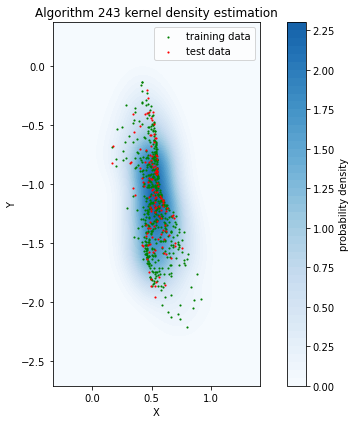

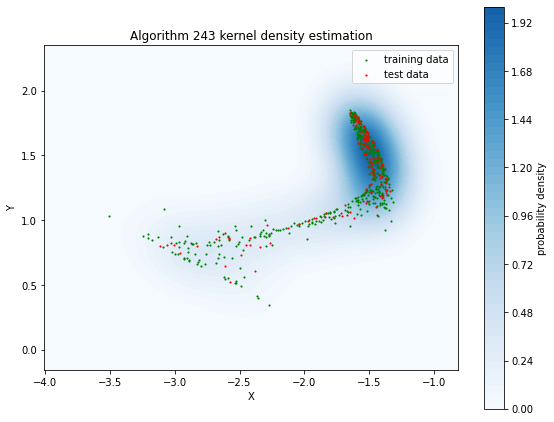

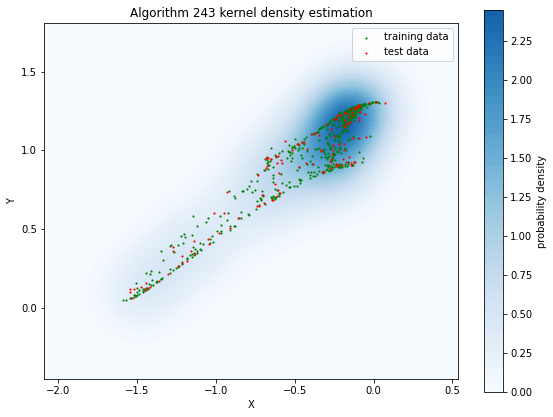

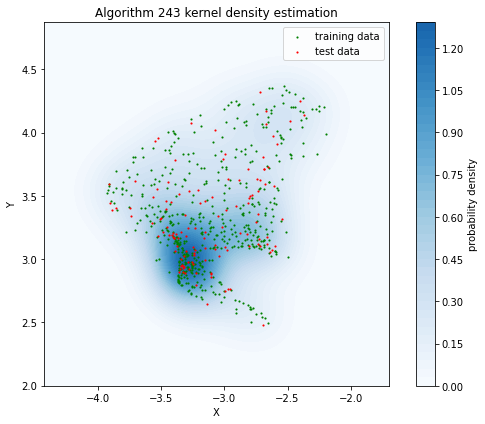

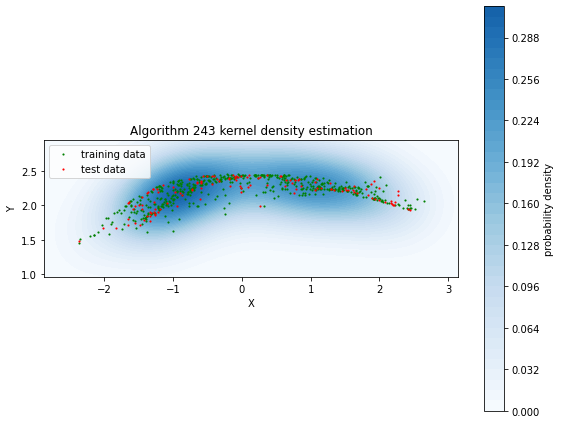

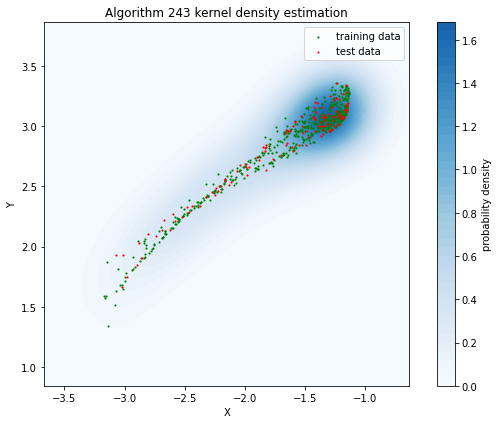

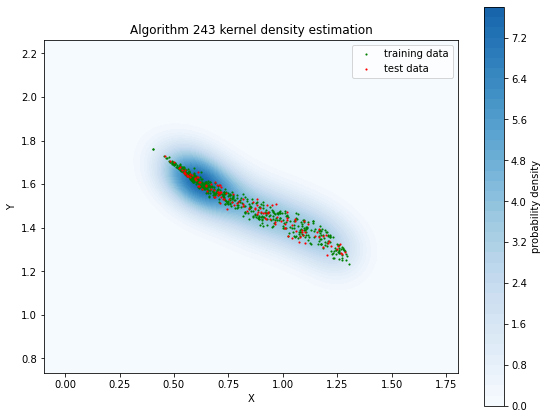

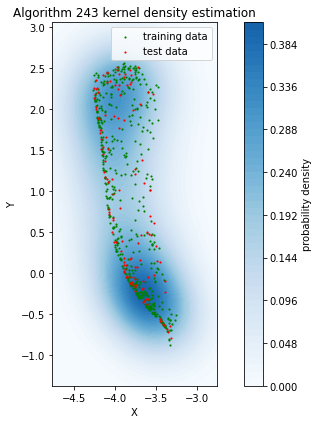

In [210]:
for ind in range(8):

    train_xs, test_xs, X, Y, log_prob_xy = plot_data[ind]
    P = np.exp(log_prob_xy)

    plt.figure(figsize=(8, 6))

    plt.contourf(X, Y, P, vmax=P.max() * 1.25, levels=50, cmap="Blues")
    plt.colorbar(label="probability density")

    plt.scatter(train_xs[:, 0], train_xs[:, 1], marker='.', s=5, c='green', label='training data')
    plt.scatter(test_xs[:, 0], test_xs[:, 1], marker='.', s=5, c='red', label='test data')

    plt.title(f"Algorithm {algo_id} kernel density estimation")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.gca().set_aspect('equal')

    plt.legend()
    plt.tight_layout()
    plt.show()